In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

Say we have some shape moving through a medium and a set of microphones surrounding it. A reasonable questions is what we can infer given the recordings over time (the pressure). Many different combinations of movement and shape can produce the same data, assuming we don't have an infinite number of microphones, but we might be still be able to do inference on a reduced set of options. I.e., classification.

To test this out we need to make a simulation somehow. For a simple test let's assume we have a 2d box of microphones and some creature that is moving inside. To encode the creature let's say it is made up of a number of pressure points which are moving over time.

In [2]:
def make_mics(size=100, step=10):
    return np.array(
        [[0, i] for i in range(0, size, step)] +
        [[i, size] for i in range(0, size, step)] +
        [[size-i, 0] for i in range(0, size, step)] +
        [[size, size-i] for i in range(0, size, step)]
    )

def rotate(points, theta, center):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
    return (points - center) @ R.T + center
    
# Creatures
class BoxCreature:
    def __init__(self):
        self.center = np.random.uniform(20, 80, size=2)
        self.rotation_speed = np.random.uniform(0.05, 0.2)
        angle = np.random.uniform(0, 2*np.pi)
        self.direction = np.array([np.cos(angle), np.sin(angle)])
        self.move_speed = np.random.uniform(0.05, 0.3)

    def __call__(self, t):
        self.center += self.direction * self.move_speed
        self.direction += 0.01 * (np.random.rand(2) - 0.5)
        self.direction /= np.linalg.norm(self.direction)
        theta = self.rotation_speed * t
        points = np.array([
            [-10, -10],
            [-10,  10],
            [10, -10],
            [10, 10],
        ]) + self.center
        return rotate(points, theta, self.center)

class WormCreature:
    def __init__(self):
        self.center = np.random.uniform(20, 80, size=2)
        angle = np.random.uniform(0, 2*np.pi)
        self.direction = np.array([np.cos(angle), np.sin(angle)])
        self.move_speed = np.random.uniform(0.05, 0.3)
        self.wave_speed = np.random.uniform(0.1, 0.3)

    def __call__(self, t):
        self.center += self.direction * self.move_speed
        self.direction += 0.01 * (np.random.rand(2) - 0.5)
        self.direction /= np.linalg.norm(self.direction)
        x = np.linspace(-20, 20, 10)
        y = 3 * np.sin(0.3 * x + self.wave_speed * t)
        points = np.stack([x, y], axis=1) + self.center
        return points

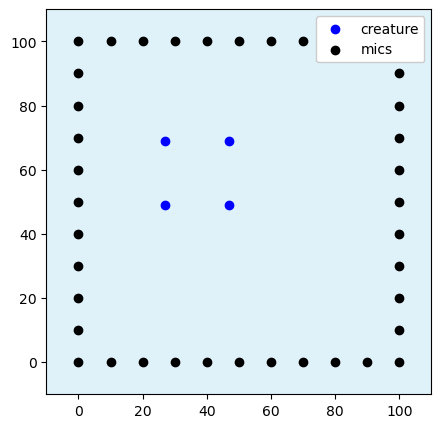

In [3]:
mics = make_mics()
creature = BoxCreature()
creature_points = creature(t=0)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_facecolor("#dff1f9")
ax.scatter(creature_points[:,0], creature_points[:,1], color="blue", label="creature")
ax.scatter(mics[:,0], mics[:,1], color="black", label="mics")
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 110)
ax.set_aspect("equal")
ax.legend(loc="upper right", framealpha=1)
plt.show()

We can also make an animation as the creature moves (rotates in this case) showing what each mic sees:

In [4]:
def mic_signal(points, mics, eps=1e-3):
    dists = np.linalg.norm(points[:, None, :] - mics[None, :, :], axis=2)
    return np.sum(1 / (dists + eps), axis=0)

def generate_trajectory(creature_fn, num_steps=100):
    traj = np.stack([creature_fn(t) for t in range(num_steps)])
    return traj

def generate_mic_data_from_traj(traj, mics, normalize=True):
    num_steps = traj.shape[0]
    signals = np.zeros((len(mics), num_steps))

    for t in range(num_steps):
        signals[:, t] = mic_signal(traj[t], mics)

    if normalize:
        signals /= signals.max()

    return signals

def animate_creature(traj, mics, signals, interval=50, save_path="creature.gif"):
    """
    Animate a creature moving along `traj` with microphones showing signals.
    Works in Jupyter Notebook and saves a GIF for GitHub.
    
    traj: np.array of shape (num_steps, num_points, 2)
    mics: np.array of shape (num_mics, 2)
    signals: np.array of shape (num_mics, num_steps)
    """
    num_steps = traj.shape[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-10, 110)
    ax.set_ylim(-10, 110)
    ax.set_aspect('equal')
    ax.set_facecolor("#dff1f9")
    ax.set_title("Creature + Microphone Signals")

    # Initial plots
    creature_plot, = ax.plot(traj[0,:,0], traj[0,:,1], 'bo', ms=8)  # blue creatures
    mic_plot = ax.scatter(mics[:,0], mics[:,1], s=300*signals[:,0], c='black', alpha=0.7)  # black mics
    
    def update(t):
        creature_plot.set_data(traj[t,:,0], traj[t,:,1])
        mic_plot.set_sizes(400 * signals[:,t])
        return creature_plot, mic_plot
        
    ani = FuncAnimation(fig, update, frames=num_steps, interval=interval, blit=True)

    # Display in Jupyter Notebook
    # display(HTML(ani.to_jshtml()))

    # Save as GIF for GitHub
    ani.save(save_path, writer=PillowWriter(fps=1000//interval))
    plt.close(fig)
    print(f"Saved animation to {save_path}")

In [5]:
mics = make_mics()
creature = BoxCreature()
traj = generate_trajectory(creature, num_steps=100)
signals = generate_mic_data_from_traj(traj, mics)
animate_creature(traj, mics, signals, save_path="box_creature.gif")

Saved animation to box_creature.gif


![Creature Animation](box_creature.gif)

And we can see the mic values over time too:

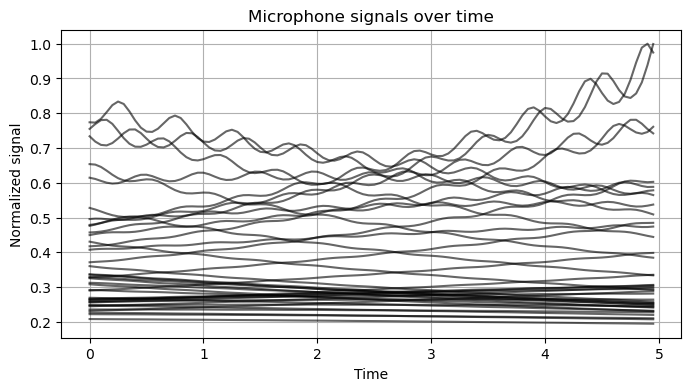

In [7]:
def plot_mic_timeseries(signals, dt=0.05):
    t = np.arange(signals.shape[1]) * dt
    plt.figure(figsize=(8, 4))
    for i in range(signals.shape[0]):
        plt.plot(t, signals[i], alpha=0.6, color="black")
    plt.xlabel("Time")
    plt.ylabel("Normalized signal")
    plt.title("Microphone signals over time")
    plt.grid(True)
    plt.show()

plot_mic_timeseries(signals)

And for the worm:

In [8]:
mics = make_mics()
creature = WormCreature()
traj = generate_trajectory(creature, num_steps=100)
signals = generate_mic_data_from_traj(traj, mics)
animate_creature(traj, mics, signals, save_path="worm_creature.gif")

Saved animation to worm_creature.gif


![Creature Animation](box_creature.gif)

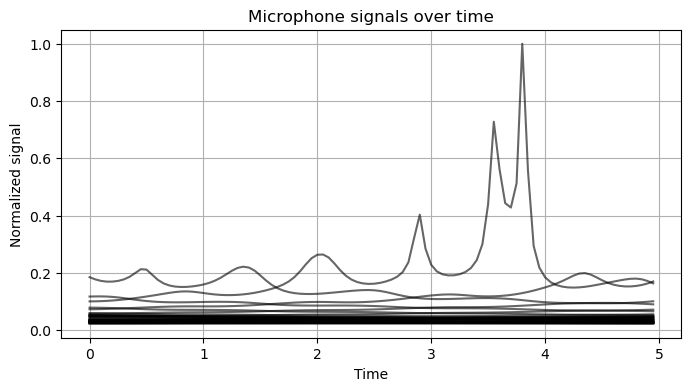

In [10]:
plot_mic_timeseries(signals)

And we can do machine learning on this data! First, collecting some:

In [11]:
box_signals = []
worm_signals = []
for i in range(500):
    box_signals.append(generate_mic_data_from_traj(generate_trajectory(BoxCreature(), num_steps=100), mics))
    worm_signals.append(generate_mic_data_from_traj(generate_trajectory(WormCreature(), num_steps=100), mics))
box_signals = np.array(box_signals)
worm_signals = np.array(worm_signals)
X = np.concatenate([box_signals,worm_signals])
y = np.concatenate([np.zeros(len(box_signals)), np.ones(len(worm_signals))])
X = X.reshape(len(X),-1) # The data is (N, M, T) where M is the number of mics and T is the number of timesteps.

And then lets a random forest and visualize the data in principal components space.

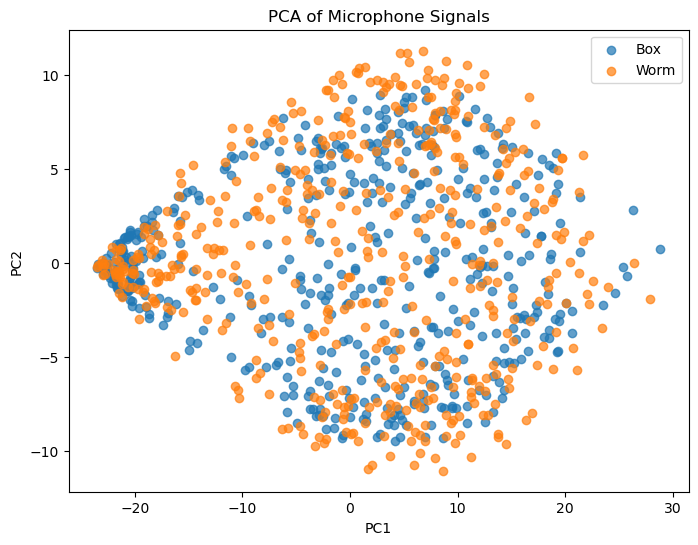

Accuracy: 0.615

Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.64      0.61        96
         1.0       0.64      0.60      0.62       104

    accuracy                           0.61       200
   macro avg       0.62      0.62      0.61       200
weighted avg       0.62      0.61      0.62       200



In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for label, color, name in zip([0,1], ['blue','orange'], ['Box', 'Worm']):
    plt.scatter(X_pca[y==label,0], X_pca[y==label,1], label=name, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Microphone Signals")
plt.legend()
plt.show()

# ----- Simple classification -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Hmmm. Not very good. But maybe a small network will do better:

Epoch 0: Train Acc=0.500, Test Acc=0.535
Epoch 5: Train Acc=0.521, Test Acc=0.520
Epoch 10: Train Acc=0.524, Test Acc=0.550
Epoch 15: Train Acc=0.560, Test Acc=0.550
Epoch 20: Train Acc=0.584, Test Acc=0.575
Epoch 25: Train Acc=0.576, Test Acc=0.560
Epoch 30: Train Acc=0.582, Test Acc=0.580
Epoch 35: Train Acc=0.677, Test Acc=0.680
Epoch 40: Train Acc=0.672, Test Acc=0.700
Epoch 45: Train Acc=0.668, Test Acc=0.665
Epoch 50: Train Acc=0.717, Test Acc=0.700
Epoch 55: Train Acc=0.746, Test Acc=0.745
Epoch 60: Train Acc=0.754, Test Acc=0.700
Epoch 65: Train Acc=0.770, Test Acc=0.760
Epoch 70: Train Acc=0.772, Test Acc=0.725
Epoch 75: Train Acc=0.780, Test Acc=0.745
Epoch 80: Train Acc=0.788, Test Acc=0.750
Epoch 85: Train Acc=0.729, Test Acc=0.720
Epoch 90: Train Acc=0.792, Test Acc=0.780
Epoch 95: Train Acc=0.797, Test Acc=0.765


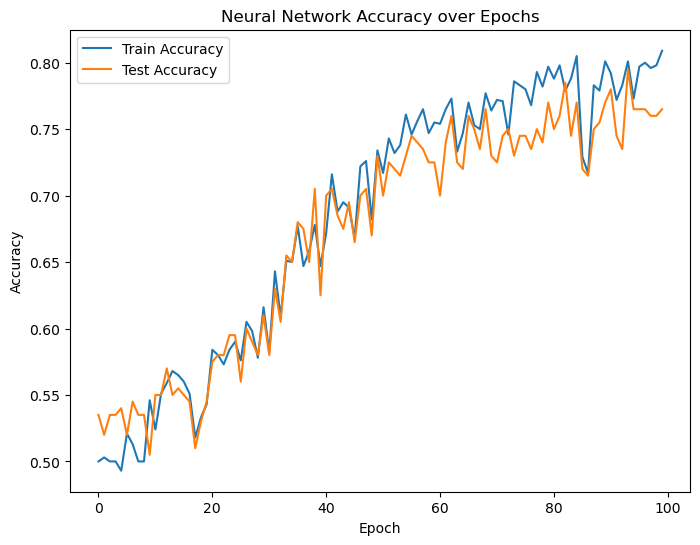

In [13]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = SimpleNet(input_dim=X.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        train_pred = (model(X_tensor) > 0.5).float()
        train_acc = (train_pred == y_tensor).float().mean().item()
        
        test_X = torch.tensor(X[test_dataset.indices], dtype=torch.float32)
        test_y = torch.tensor(y[test_dataset.indices], dtype=torch.float32).unsqueeze(1)
        test_pred = (model(test_X) > 0.5).float()
        test_acc = (test_pred == test_y).float().mean().item()
    
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

plt.figure(figsize=(8,6))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Neural Network Accuracy over Epochs")
plt.legend()
plt.show()

A little bit better! Proof of concept at least. 